# Practical session 3 - Brownian motion, Fourier transform

Students (pair):
- [Student 1]([link](https://github.com/username1))
- [Student 2]([link](https://github.com/username2))

```
conda create --name=lab3 --file=requirement.txt
conda activate lab3
# do not forget to deactivate the environment if needed
# you can remove the environment once you are done
conda env remove --name=lab3
```

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import pandas as pd
import unittest

## <a name="ex1">Exercise 1: Brownian motion</a>

This first exercise consists in generating a Brownian motion on the closed unit ball $\mathcal{B}(\mathbf{0}, 1) = \{ \mathbf{x} \mid \Vert \mathbf{x} \Vert  \leq 1\}$, focusing first on the 2-D case. The Brownian motion is a random walk with independent, identically distributed Gaussian increments, appearing for instance in thermodynamics and statistical mechanics (to model the evolution of a large particle in a medium composed of a large number of small particles, ...). It is also connected to the diffusion process (Einstein).

Let $N \in \mathbb{N}^*$, $\delta > 0$, and $\mathbf{x} = (x_1, x_2) \in  \mathcal{B}(\mathbf{0}, 1)$. The first $N$ steps of a 2-D discrete-time Brownian motion $W$ can be generated as follows

\begin{align*}
    W_0 &= \mathbf{x}, \\
    %
    (\forall n \in \{1, \dotsc, N-1 \}), \quad W_n &= W_{n−1} + \sqrt{\delta} G_n, \quad G_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),
\end{align*}

where $\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a Gaussian distribution with mean $\mathbf{0}$ and identity covariance matrix.

1. Define a random generator `rng`, set to a known state for reproducibility (see session 2).<>

**Answer:**

In [33]:
rng = np.random.default_rng(seed=42)

2. Implement a function `brownian_motion(niter, x, step, rng)` which

    - simulates $W$ until it reaches the boundary of $\mathcal{B}(\mathbf{0}, 1)$, using a maximum of $N$ iterations (`niter`), a starting point $\mathbf{x} \in \mathcal{B}(\mathbf{0}, 1)$ (`x`) and step-size $\delta$ (`step`);
    - interpolates linearly between the two last positions to determine the points $W^*$ where the trajectory crosses the boundary (if applicable);
    - returns both the whole random walk $W$ and, if appropriate, the point at the intersection between the last segment of the trajectory and $\mathcal{B}(\mathbf{0}, 1)$.
 
> Hint: 
> - you can easily derive a closed form expression for $W^*$, observing that $\Vert W^* \Vert^2= 1$ and $W^* \in [W_{n-1}, W_n]$. 
> - you can also take a look at [`np.roots`](https://numpy.org/doc/stable/reference/generated/numpy.roots.html?highlight=roots#numpy.roots) if needed.

> Recall of the Linear Interpolation (LERP) for $n$-dimensional vectors:
> - Clearly, $\vec{D}=\alpha \vec{C}$ with $\alpha \in [0, 1]$ and hence $\vec{P}-\vec{B}= \alpha (\vec{A}-\vec{B})$ which is equivalent to $\vec{P}= (1-\alpha) \vec{B} + \alpha \vec{A}$. 
![alternatvie text](img/for_Course.png)

**Answer:**

In [34]:
def brownian_motion(niter, x, step, rng):
    W = [x]
    boundary_radius = 1.0

    for _ in range(niter):
        direction = rng.normal(size=2) #retourne un vecteur de dimension 2 aléatoire normal centré réduit
        direction /= np.linalg.norm(direction)
        new_position = W[-1] + np.sqrt(step) * direction

        if np.linalg.norm(new_position) >= boundary_radius: #si le point obtenu est en dehors du cercle unitaire
            W_star = find_intersection(W[-1], new_position, boundary_radius)
            W.append(W_star)
            return np.array(W), W_star

        W.append(new_position)

    return np.array(W), None


def find_intersection(last_position, new_position, boundary_radius):
    D = new_position - last_position #vecteur directeur entre la dernière et la nouvelle position de W
    # On veut trouver le point d'intersection entre la droite x=x0+tDx & y= y0+tDy et le cercle x²+y²=1
    # on trouve une équation du second degré avec les coefficients suivants :
    a = np.dot(D, D)
    b = 2 * np.dot(last_position, D)
    c = np.dot(last_position, last_position) - boundary_radius**2
    alphas = np.roots([a, b, c])
    alpha = np.max(alphas[(alphas >= 0) & (alphas <= 1)]) #je veux la racine entre 0 et 1
    W_star = last_position + alpha * D
    # assert np.linalg.norm(W_star) == 1
    return W_star


start_point = np.array([0.2, 0.3])

trajectory, intersection_point = brownian_motion(niter=1000, x=start_point, step=0.1, rng=rng)

print("Trajectoire:\n", trajectory)
print("Point d'intersection avec la frontière:", intersection_point)


Trajectoire:
 [[ 0.2         0.3       ]
 [ 0.28891708 -0.00346953]
 [ 0.48614224  0.24371914]
 [ 0.22311754  0.06816855]
 [ 0.34163442 -0.22501015]
 [ 0.33540735 -0.5411766 ]
 [ 0.57227918 -0.33167305]
 [ 0.59077123 -0.01598643]
 [ 0.7418996  -0.2937637 ]
 [ 0.83848615 -0.54492291]]
Point d'intersection avec la frontière: [ 0.83848615 -0.54492291]


3. Diplay the trajectory of a Brownian motion starting from $\mathbf{x} = (0.2, 0.4)$, using $\delta = 10^{-2}$, $N = 1000$. Display the unit circle on the same figure, and highlight the intersection with the boundary of the domain (whenever it exists).

> Hint: to draw the unit disk, you can use for instance:
> ```python
> circle = plt.Circle((0,0), 1)
> fig, ax = plt.subplots()
> plt.xlim(-1.25,1.25)
> plt.ylim(-1.25,1.25)
> plt.grid(linestyle = "--", zorder = 1)
> ax.set_aspect(1)
> ax.add_artist(circle)
> ```

**Answer:**

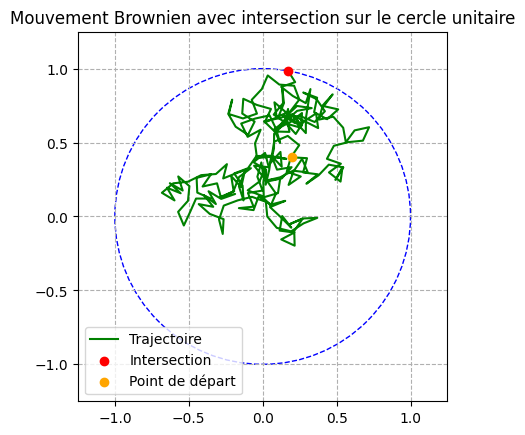

In [35]:
# Initialisation du générateur de nombres aléatoires et paramètres
start_point = np.array([0.2, 0.4])
step_size = 1e-2
n_iterations = 1000

# Simuler le mouvement brownien
trajectory, intersection_point = brownian_motion(niter=n_iterations, x=start_point, step=step_size, rng=rng)

# Tracer la trajectoire du mouvement brownien
fig, ax = plt.subplots()

# Tracé du cercle unitaire
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
ax.add_artist(circle)

# Limites des axes et aspect du graphique
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.grid(linestyle="--", zorder=1)
ax.set_aspect(1)

# Tracé de la trajectoire
plt.plot(trajectory[:, 0], trajectory[:, 1], color="green", label="Trajectoire", zorder=2)

# Mise en évidence du point d'intersection (si trouvé)
if intersection_point is not None:
    plt.scatter(*intersection_point, color='red', label="Intersection", zorder=3)

# Point de départ
plt.scatter(*start_point, color='orange', label="Point de départ", zorder=3)

# Affichage de la légende
plt.legend()

# Afficher le graphique
plt.title("Mouvement Brownien avec intersection sur le cercle unitaire")
plt.show()

4. Represent, on the same figure, 4 other trajectories of $W$ with the same parameters.

**Answer:**

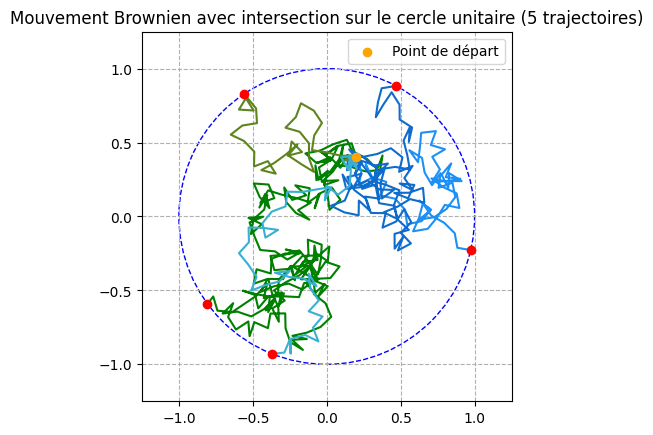

In [36]:
start_point = np.array([0.2, 0.4])
step_size = 1e-2
n_iterations = 1000

# Initialisation du graphique
fig, ax = plt.subplots()

# Tracé du cercle unitaire
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
ax.add_artist(circle)

# Limites des axes et aspect du graphique
plt.xlim(-1.25, 1.25)
plt.ylim(-1.25, 1.25)
plt.grid(linestyle="--", zorder=1)
ax.set_aspect(1)

# Fonction pour tracer une trajectoire et l'intersection
def plot_trajectory(trajectory, intersection_point, color):
    # Tracé de la trajectoire
    plt.plot(trajectory[:, 0], trajectory[:, 1], color=color, zorder=2)
    # Mise en évidence du point d'intersection (si trouvé)
    if intersection_point is not None:
        plt.scatter(*intersection_point, color='red', zorder=3)

# Simuler et tracer la première trajectoire
trajectory, intersection_point = brownian_motion(niter=n_iterations, x=start_point, step=step_size, rng=rng)
plot_trajectory(trajectory, intersection_point, color="green")


# Simuler et tracer quatre autres trajectoires
for i in range(2, 6):
    trajectory, intersection_point = brownian_motion(niter=n_iterations, x=start_point, step=step_size, rng=np.random.default_rng(seed=i))
    plot_trajectory(trajectory, intersection_point, color=np.random.rand(3,))

# Point de départ
plt.scatter(*start_point, color='orange', label="Point de départ", zorder=3)

# Affichage de la légende
plt.legend()

# Afficher le graphique
plt.title("Mouvement Brownien avec intersection sur le cercle unitaire (5 trajectoires)")
plt.show()

5. [Bonus] Generalize the procedure to a $M$-dimensional Brownian motion, $M > 2$.

**Answer:**

/var/folders/49/60cw9lw504761bbvj9snc4yc0000gn/T/ipykernel_18683/1640095036.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


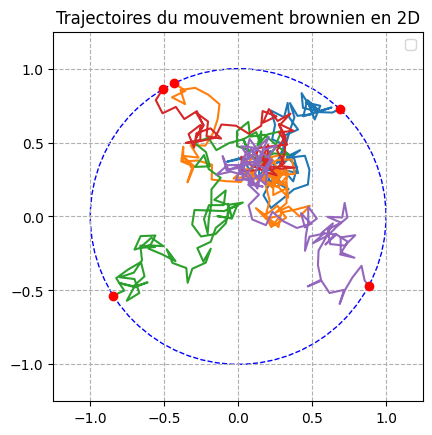

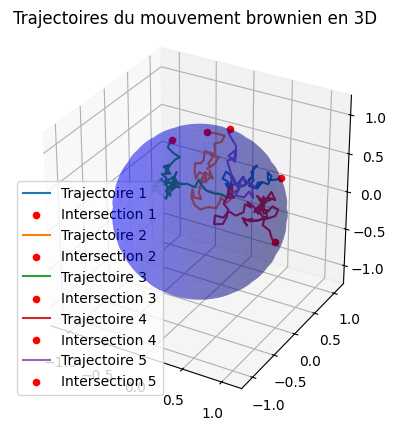

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def brownian_motion(niter, x, step, rng):
    W = [x]
    boundary_radius = 1.0

    for _ in range(niter):
        direction = rng.normal(size=x.shape)  # Générer une direction dans l'espace M-dimensionnel
        direction /= np.linalg.norm(direction)

        new_position = W[-1] + np.sqrt(step) * direction

        if np.linalg.norm(new_position) >= boundary_radius:
            W_star = find_intersection(W[-1], new_position, boundary_radius)
            W.append(W_star)
            return np.array(W), W_star

        W.append(new_position)

    return np.array(W), None

def find_intersection(last_position, new_position, boundary_radius):
    D = new_position - last_position
    a = np.dot(D, D)
    b = 2 * np.dot(last_position, D)
    c = np.dot(last_position, last_position) - boundary_radius**2
    alphas = np.roots([a, b, c])
    alpha = np.max(alphas[alphas >= 0])
    W_star = (1 - alpha) * last_position + alpha * new_position
    return W_star

# Fonction pour tracer en 2D
def plot_2D(trajectories, intersections):
    fig, ax = plt.subplots()

    # Tracé du cercle unitaire en 2D
    circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--')
    ax.add_artist(circle)

    # Limites des axes et aspect
    plt.xlim(-1.25, 1.25)
    plt.ylim(-1.25, 1.25)
    plt.grid(linestyle="--", zorder=1)
    ax.set_aspect(1)

    # Tracer les trajectoires
    for i, (trajectory, intersection_point) in enumerate(zip(trajectories, intersections)):
        plt.plot(trajectory[:, 0], trajectory[:, 1], zorder=2)
        if intersection_point is not None:
            plt.scatter(intersection_point[0], intersection_point[1], color='red', zorder=3)

    plt.legend()
    plt.title("Trajectoires du mouvement brownien en 2D")
    plt.show()

# Fonction pour tracer en 3D
def plot_3D(trajectories, intersections):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Tracé de la sphère unitaire
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x_sphere = np.outer(np.cos(u), np.sin(v))
    y_sphere = np.outer(np.sin(u), np.sin(v))
    z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='blue', alpha=0.3, rstride=5, cstride=5)

    # Tracer les trajectoires en 3D
    for i, (trajectory, intersection_point) in enumerate(zip(trajectories, intersections)):
        ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], label=f'Trajectoire {i+1}')
        if intersection_point is not None:
            ax.scatter(intersection_point[0], intersection_point[1], intersection_point[2], color='red', label=f'Intersection {i+1}')

    # Limites des axes et réglage de la vue
    ax.set_xlim([-1.25, 1.25])
    ax.set_ylim([-1.25, 1.25])
    ax.set_zlim([-1.25, 1.25])
    ax.set_box_aspect([1, 1, 1])  # Aspect égal sur les trois axes

    plt.legend()
    plt.title("Trajectoires du mouvement brownien en 3D")
    plt.show()

# Simulation du mouvement brownien en 2D et 3D
def simulate_and_plot():
    M_2D = 2  # Dimension de l'espace 2D
    M_3D = 3  # Dimension de l'espace 3D
    step_size = 1e-2
    n_iterations = 1000
    rng = np.random.default_rng()

    # Point de départ
    start_point_2D = np.array([0.2, 0.4])  # Pour 2D
    start_point_3D = np.array([0.2, 0.4, 0.1])  # Pour 3D

    # Simuler 5 trajectoires en 2D
    trajectories_2D = []
    intersections_2D = []
    for i in range(5):
        trajectory, intersection_point = brownian_motion(niter=n_iterations, x=start_point_2D, step=step_size, rng=np.random.default_rng())
        trajectories_2D.append(trajectory)
        intersections_2D.append(intersection_point)

    # Simuler 5 trajectoires en 3D
    trajectories_3D = []
    intersections_3D = []
    for i in range(5):
        trajectory, intersection_point = brownian_motion(niter=n_iterations, x=start_point_3D, step=step_size, rng=np.random.default_rng())
        trajectories_3D.append(trajectory)
        intersections_3D.append(intersection_point)

    # Afficher en 2D
    plot_2D(trajectories_2D, intersections_2D)

    # Afficher en 3D
    plot_3D(trajectories_3D, intersections_3D)

# Exécuter la simulation et l'affichage
simulate_and_plot()


---
## <a name="ex2">Exercise 2: 2D Fourier transform, ideal low-pass filter and linear convolution</a>

In this exercise, we explore the use of the 2-dimensional Fourier transform to filter an image, and convolve it with a blurring kernel.

1\. Load and display one of the images contained in the `img/` folder. The image will be denoted by $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ in the rest of this exercise.

**Answer:**

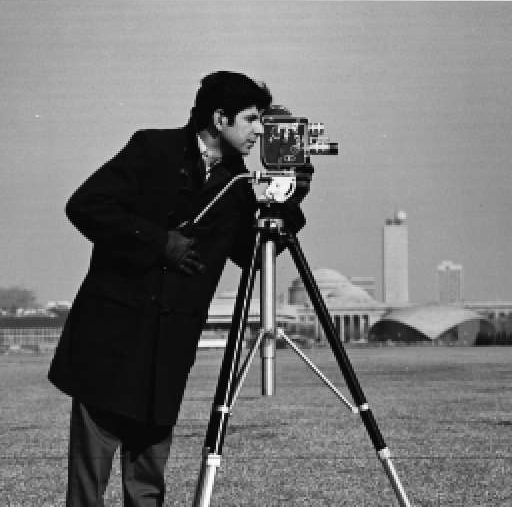

In [38]:
from PIL import Image
from IPython.display import display

img = Image.open('img/cameraman.png')
display(img)

2\. Let $\mathcal{F}$ denote the 2D discrete Fourier transform. Compute $|\mathcal{F}(\mathbf{X})|^2$, the spectrum of the image $\mathbf{X} \in \mathbb{R}^{M_1 \times N_1}$ (i.e., the term-wise squared absolute value of its Fourier transform) loaded in 1. Display the result in logarithmic scale.

a) In this representation, where is the pixel of the spectrum associated with the null frequency located?
    
b) Take a look at the documentation of `np.fft.fftshift`. Use it to ensure that the null frequency is located at the center of the image. 

**Answer:**

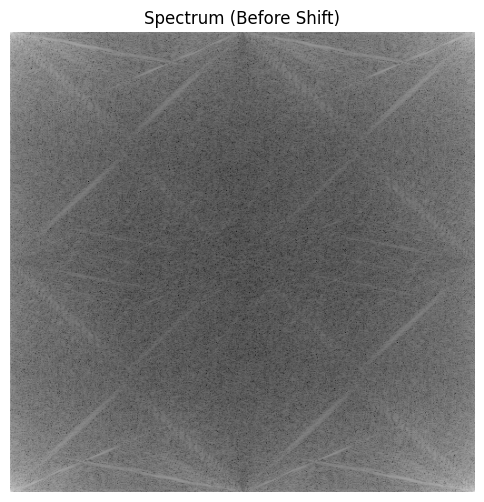

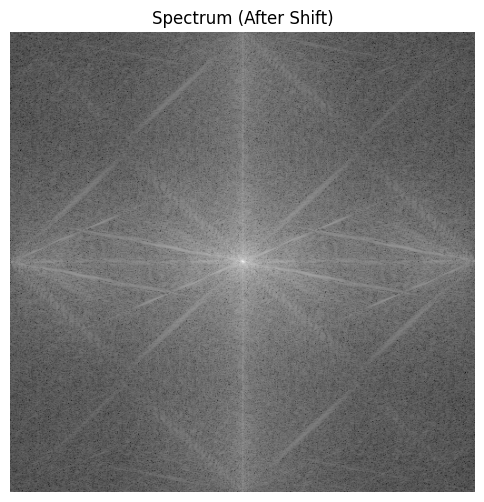

In [39]:
# Vérifie que l'image est en niveaux de gris
img_array = np.array(img)
assert len(img_array.shape) == 2, "L'image n'est pas en niveaux de gris."

# Fonction pour calculer la transformée de Fourier 2D et retourner le spectre de magnitude
def compute_spectrum(image_array):
    F = np.fft.fft2(image_array)  # Calcule la transformée de Fourier 2D
    spectrum = np.abs(F)**2  # Calcule la magnitude au carré
    log_spectrum = np.log(1 + spectrum)  # Applique une échelle logarithmique
    return log_spectrum

# Calcule le spectre pour l'image en niveaux de gris
spectrum = compute_spectrum(img_array)

# Affiche le résultat avant le décalage (échelle logarithmique)
plt.figure(figsize=(6, 6))
plt.imshow(spectrum, cmap='gray')
plt.title('Spectre (Avant Décalage)')
plt.axis('off')
plt.show()

# Utilise fftshift pour déplacer la fréquence nulle au centre
shifted_spectrum = np.fft.fftshift(spectrum)

# Affiche le résultat après le décalage
plt.figure(figsize=(6, 6))
plt.imshow(shifted_spectrum, cmap='gray')
plt.title('Spectre (Après Décalage)')
plt.axis('off')
plt.show()

3\. 
    a) Create a function `ideal_lowpass_filter` to filter $\mathbf{X}$ by an ideal low-pass filter. The filter preserves Fourier coefficients associated to frequencies below a cutoff specified in each direction ($\mathbf{f}_c = (f_{c,y}, f_{c,x})$), and sets others to zero. For simplicity, $f_{c,y}$ and $f_{c,x}$ can be expressed as a number of samples to be kept along each dimension (e.g., $\mathbf{f}_c = (50,50)$).

b) Display the filtered image for 2 different values of $\mathbf{f}_c$. What do you observe as the cutoff frequencies increase?
    
> Warning: beware the type of the array after `np.fft.fft2`, do not hesitate to specify the type if you make copies from this array
> ```python
> a = np.zeros((2,2), dtype=np.complex)
> ...
> ```

**Answer:**

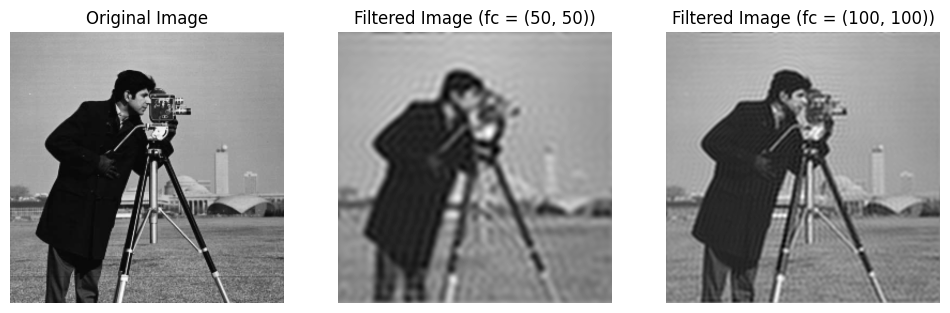

In [40]:
def ideal_lowpass_filter(X, fc):
    # Perform 2D Fourier transform
    X_fft = np.fft.fft2(X)

    # Shift the zero frequency component to the center
    X_fft_shifted = np.fft.fftshift(X_fft)

    # Get the shape of the array
    rows, cols = X.shape

    # Create a mask to keep only the low frequencies
    mask = np.zeros((rows, cols), dtype=np.complex128)

    # Set the central region to 1 (preserve these frequencies)
    fc_y, fc_x = fc
    start_y, end_y = (rows // 2 - fc_y // 2, rows // 2 + fc_y // 2)
    start_x, end_x = (cols // 2 - fc_x // 2, cols // 2 + fc_x // 2)

    mask[start_y:end_y, start_x:end_x] = 1

    # Apply the mask to the shifted Fourier transform
    X_fft_filtered = X_fft_shifted * mask

    # Inverse shift and inverse Fourier transform to get the filtered image back in spatial domain
    X_fft_filtered_shifted_back = np.fft.ifftshift(X_fft_filtered)
    X_filtered = np.fft.ifft2(X_fft_filtered_shifted_back)

    # Return the real part of the inverse Fourier transform
    return np.real(X_filtered)

# Step 2: Test the filter with two different cutoff frequencies and display the results
# Create a sample 2D array (image) for testing
X = img_array

# Apply the filter with two different cutoff frequencies
fc_1 = (50, 50)
fc_2 = (100, 100)

X_filtered_1 = ideal_lowpass_filter(X, fc_1)
X_filtered_2 = ideal_lowpass_filter(X, fc_2)

# Plot the original and filtered images for comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(X_filtered_1, cmap='gray')
plt.title(f'Filtered Image (fc = {fc_1})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(X_filtered_2, cmap='gray')
plt.title(f'Filtered Image (fc = {fc_2})')
plt.axis('off')

plt.show()

4\. Let $\mathbf{H} \in \mathbb{R}^{M_2\times N_2}$ be a 2-D Gaussian kernel, obtained as the outer product of two 1-D Gaussian windows $\mathbf{w}_y \in \mathbb{R}^{M_2}$ and $\mathbf{w}_x \in \mathbb{R}^{N_2}$, of standard deviation $\sigma_y = 10$ and $\sigma_x = 10$, respectively:

\begin{equation}
    \mathbf{H} = \mathbf{w}_y \mathbf{w}_x^T.
\end{equation}

Let $M = M_1+M_2-1$ and $N =  N_1+N_2-1$. From the discrete convolution theorem, the linear convolution between $\mathbf{H}$ and $\mathbf{X}$ can be computed as follows

\begin{equation}
    \mathbf{X} \star \mathbf{H} = \mathcal{F}^{-1} \Big( \mathcal{F}\big(P_1(\mathbf{X})\big) \odot \mathcal{F}\big(P_2(\mathbf{H})\big) \Big) \in \mathbb{R}^{M\times N},
\end{equation}

where $P_i: \mathbb{R}^{M_i \times N_i} \rightarrow \mathbb{R}^{M \times N}$, $i \in \{1, 2\}$, are 0-padding operators, $\odot$ is the Hadamard (= term-wise) product, $\mathcal{F}^{-1}$ is the 2D discrete inverse Fourier transform.

Compute and display $\mathbf{X} \star \mathbf{H}$, for $M_2 = N_2 = 10$. What do you observe?

> Hint: 
> - the usual 0-padding procedure in image space consists in appending trailing zeros. For instance (in 1D), 0-padding a vector $\mathbf{x} \in \mathbb{R}^N_1$ to the size $N>N_1$ corresponds to creating the vector
\begin{bmatrix}
\mathbf{x} \\
\mathbf{0}_{N-N_1}
\end{bmatrix}
> - since the input images are real, $\mathcal{F}(\mathbf{x})$ and $\mathcal{F}(\mathbf{h})$ are Hermitian symmetric. In this case, a more efficient version of `np.fft.fft2` can be used, computing only quarter of the Fourier coefficients (half of the Fourier coefficients in each direction): [`np.fft.rfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.rfft2.html?highlight=rfft#numpy.fft.rfft2). Its inverse, [`np.fft.irfft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft2.html#numpy.fft.irfft2), also ensures that the output is real;
> - the 2D Gaussian window can be generated as the outer product of two 1D Gaussian windows (one window for each dimension);
> - you can take a look at [scipy.signal.windows.gaussian](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.gaussian.html#scipy.signal.windows.gaussian) and [np.newaxis](https://numpy.org/doc/stable/reference/constants.html?highlight=newaxis#numpy.newaxis) (or `np.reshape` or built-in `np.outer`).

**Answer:**

Text(0.5, 1.0, 'Gaussian window H')

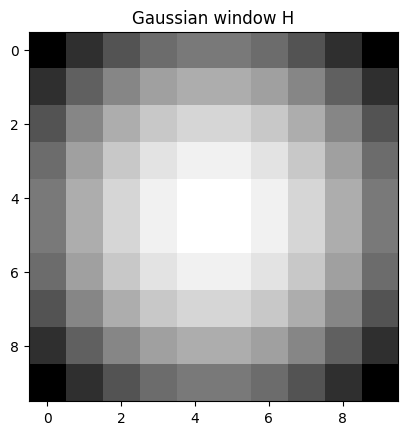

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows

# Step 1: Create the 1D Gaussian windows and construct the 2D Gaussian kernel
M2, N2 = 10, 10  # Size of the Gaussian kernel
sigma_y, sigma_x = 10, 10  # Standard deviations

# Generate the 1D Gaussian windows
w_y = windows.gaussian(M2, std=sigma_y)
w_x = windows.gaussian(N2, std=sigma_x)

# Create the 2D Gaussian kernel as the outer product of w_y and w_x
H = np.outer(w_y, w_x)

# 2D Gaussian window
plt.imshow(H, cmap='gray')
plt.title("Gaussian window H")


Text(0.5, 1.0, 'Padded H')

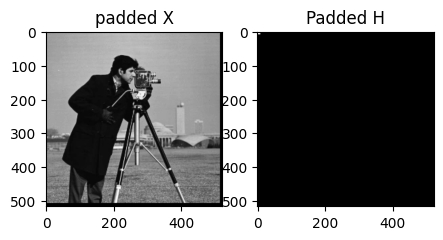

In [42]:
# Step 2: Create a random 2D image for testing
M1, N1 = X.shape  # Assuming X is an input image

# Step 3: Zero-pad both X and H to the size M x N
M, N = M1 + M2 - 1, N1 + N2 - 1  # Size of the padded arrays
P1_X = np.zeros((M, N))
P2_H = np.zeros((M, N))

# Insert the original X and H into the top-left corner of the zero-padded arrays
P1_X[:M1, :N1] = X
P2_H[:M2, :N2] = H

plt.figure(figsize=(5,5))
axis = plt.subplot(1,2,1)
axis.imshow(P1_X, cmap='gray')
axis.set_title("padded X")
axis = plt.subplot(1,2,2)
axis.imshow(P2_H, cmap='gray')
axis.set_title("Padded H")


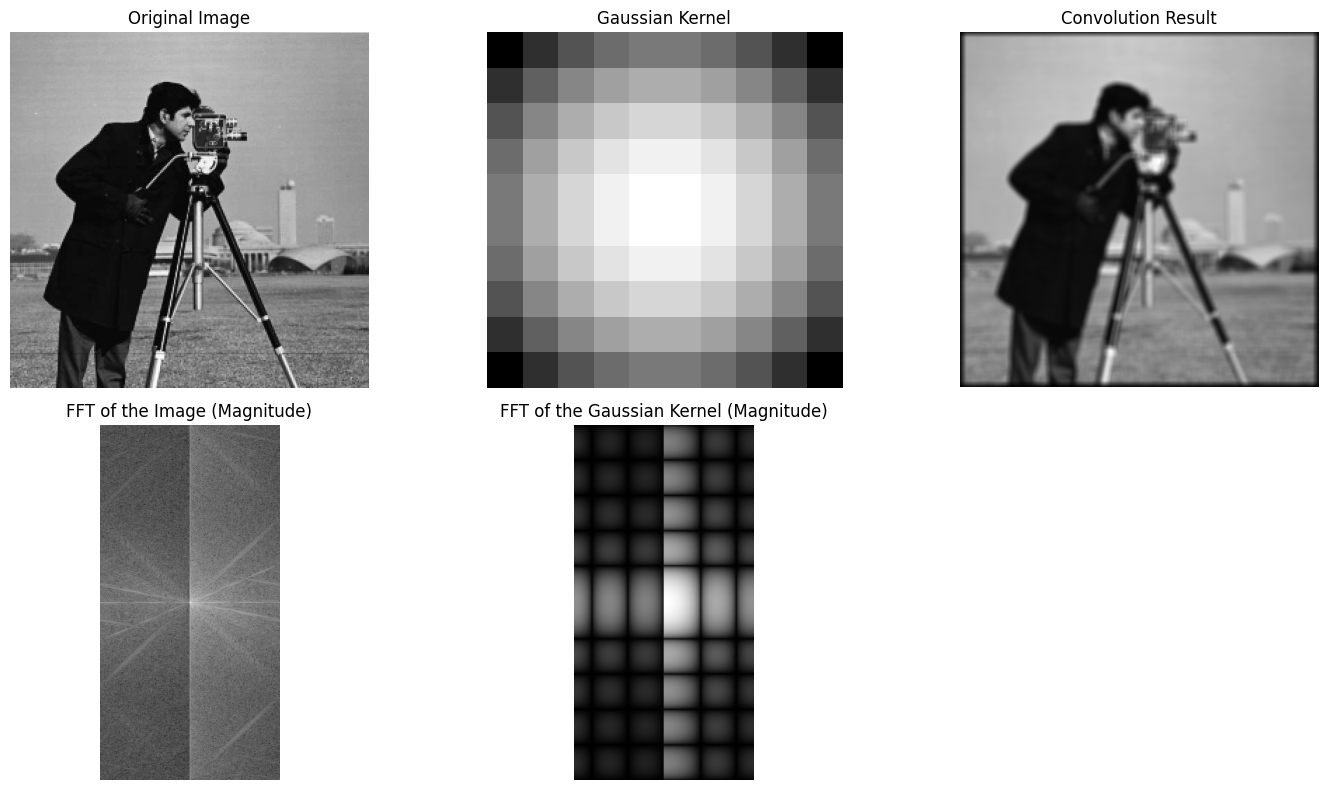

In [43]:

# Step 4: Perform Fourier transforms
X_fft = np.fft.rfft2(P1_X)
H_fft = np.fft.rfft2(P2_H)

# Step 5: Multiply the Fourier transforms element-wise
convolution_fft = X_fft * H_fft

# Step 6: Perform the inverse Fourier transform to get the result in the spatial domain
result = np.fft.irfft2(convolution_fft, s=(M, N))

# Step 7: Display the original image, Gaussian kernel, FFTs, and convolution result
plt.figure(figsize=(15, 8))

# Original Image
plt.subplot(2, 3, 1)
plt.imshow(X, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Gaussian Kernel
plt.subplot(2, 3, 2)
plt.imshow(H, cmap='gray')
plt.title("Gaussian Kernel")
plt.axis('off')

# Convolution Result
plt.subplot(2, 3, 3)
plt.imshow(result, cmap='gray')
plt.title("Convolution Result")
plt.axis('off')

# Magnitude Spectrum of the Fourier Transform of the Image
plt.subplot(2, 3, 4)
plt.imshow(np.log(np.abs(np.fft.fftshift(X_fft)) + 1), cmap='gray')
plt.title("FFT of the Image (Magnitude)")

plt.axis('off')

# Magnitude Spectrum of the Fourier Transform of the Gaussian Kernel
plt.subplot(2, 3, 5)
plt.imshow(np.log(np.abs(np.fft.fftshift(H_fft)) + 1), cmap='gray')
plt.title("FFT of the Gaussian Kernel (Magnitude)")
plt.axis('off')

plt.tight_layout()
plt.show()

We observe that after applying the convolution, the image becomes blurred, similar to applying a low-frequency filter. In the FFT of the Gaussian kernel, we notice that the center is bright, while the borders are dim. This indicates that when multiplied with the FFT of the image, we predominantly retain the low frequencies (at the center) while attenuating the high frequencies (near the borders).